# Análise de série temporal

In [1]:
# gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Dict
import matplotlib.ticker as mtick

In [2]:
# series temporais
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [3]:
df_mensal = pd.read_csv('../data/faturamento_2022_2025.csv', sep = ';', decimal = ',', encoding = 'latin1')

In [4]:
df_mensal['data'] = pd.to_datetime(df_mensal['data'])

In [5]:
df = df_mensal.set_index('data')
df = df.asfreq('MS')

In [6]:
df['log_faturamento'] = np.log(df['faturamento'])

In [7]:
def create_month_dummies(df, months_to_track):
    """
    Cria colunas dummy (0 ou 1) para os meses especificados.
    :param df: DataFrame com índice temporal.
    :param months_to_track: Lista de meses (números 1 a 12). Ex: [3, 11, 12].
    :return: DataFrame com as novas colunas dummy.
    """
    df_with_dummies = df.copy()
    
    # 1. Extrair o mês do índice
    months = df.index.month
    
    for month in months_to_track:
        col_name = f'mes_{month}'
        # Cria a coluna, 1 se o mês for o especificado, 0 caso contrário
        df_with_dummies[col_name] = (months == month).astype(int)
        
    return df_with_dummies

In [8]:
MONTHS_OF_INTEREST = list(range(1, 13))
df = create_month_dummies(df, MONTHS_OF_INTEREST)

## Detecção da estacionariedade

In [9]:
teste_adf = adfuller(df['faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -5.1591 (p-value: 0.0000)


In [10]:
teste_adf = adfuller(df['log_faturamento'])
print(f"Estatística ADF: {teste_adf[0]:.4f} (p-value: {teste_adf[1]:.4f})")

Estatística ADF: -4.9406 (p-value: 0.0000)


## Identificação

- AR (p)

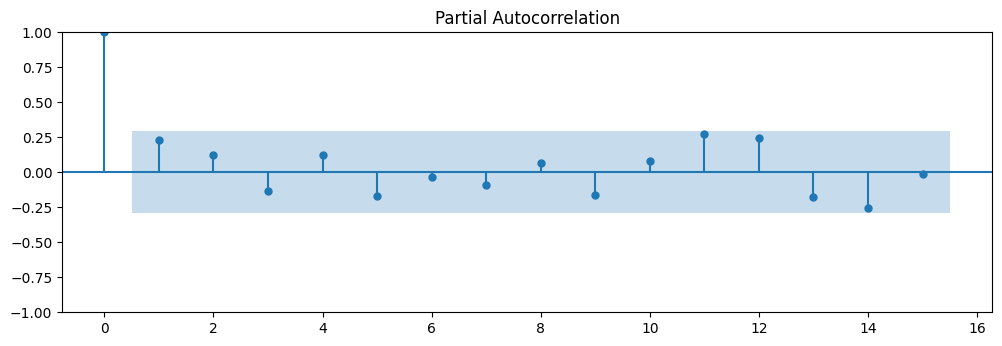

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'], lags=15, ax=ax1)

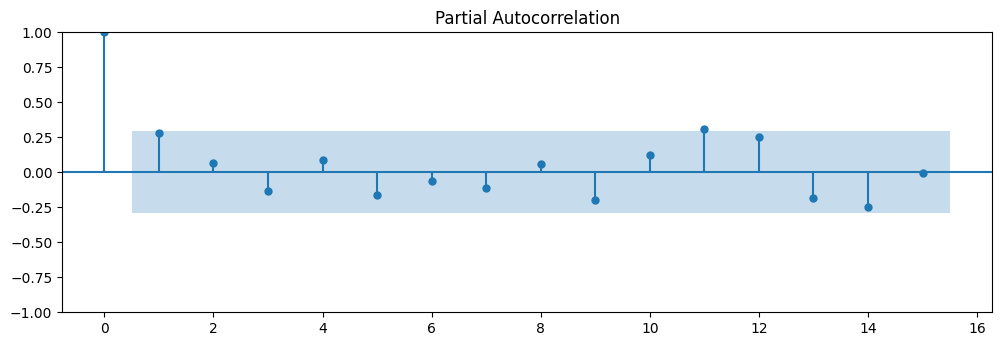

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']), lags=15, ax=ax1)

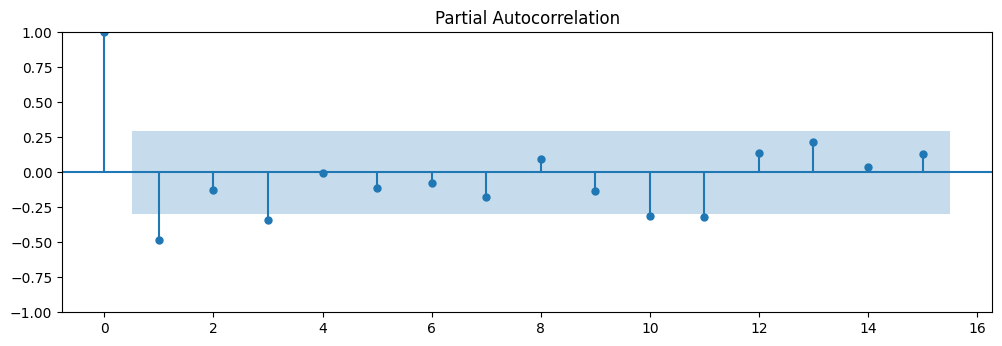

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

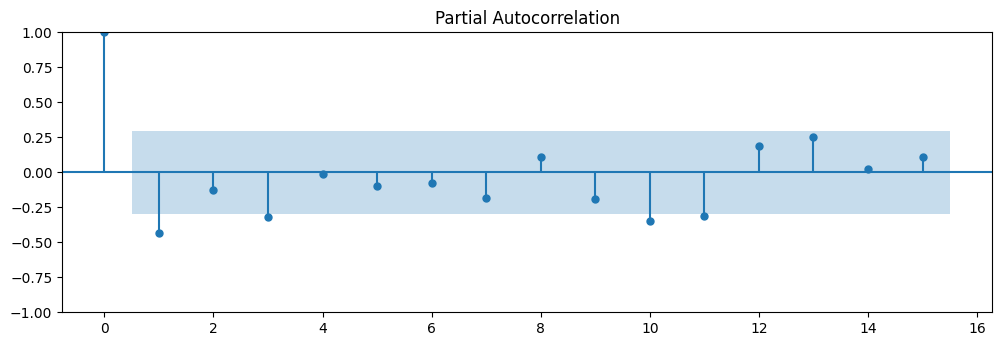

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_pacf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

- MA(q)

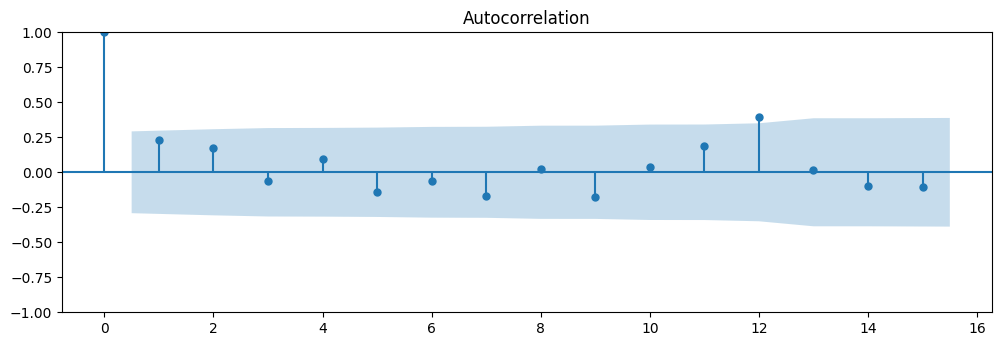

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'], lags=15, ax=ax1)

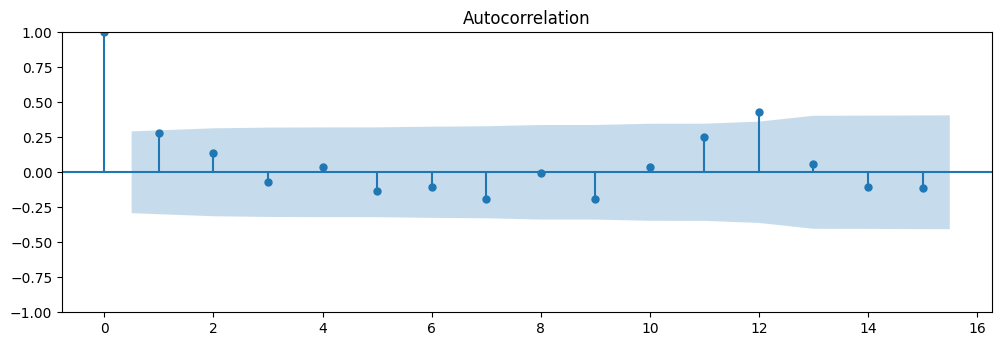

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']), lags=15, ax=ax1)

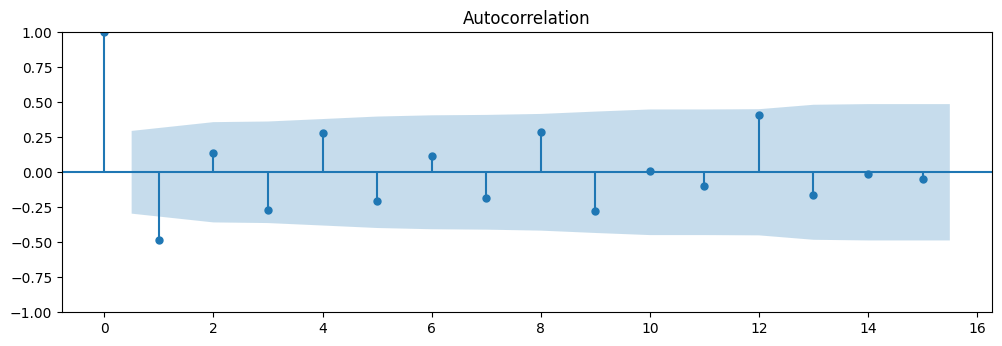

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['faturamento'].diff(1).dropna(), lags=15, ax=ax1)

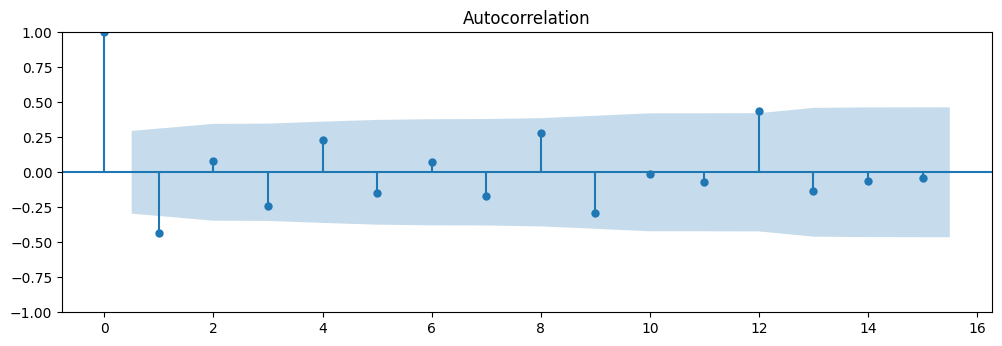

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(np.log(df['faturamento']).diff(1).dropna(), lags=15, ax=ax1)

## Modelo Box-Jenkins

(vamos tentar mesmo assim)

In [19]:
def create_sparse_mask(ar_lags=None, ma_lags=None, sar_lags=None, sma_lags=None):
    """
    Cria os arrays de máscara de atividade (1 ativo, 0 fixo em zero) 
    para os lags AR e MA com base nas listas fornecidas.

    :param ar_lags: Lista de lags AR que DEVEM SER ATIVOS (ex: [1, 10]).
    :param ma_lags: Lista de lags MA que DEVEM SER ATIVOS (ex: [1]).
    :return: Quatro arrays (AR, MA, SAR, SMA) com 1 para ativo e 0 para fixo em zero.
    """
    
    # 1. Determinar as ordens máximas (p e q)
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    P = max(sar_lags) if sar_lags else 0
    Q = max(sma_lags) if sma_lags else 0
    
    # 2. Inicializar as máscaras com 0 (tudo inativo por padrão)
    ar_mask = np.zeros(p)
    ma_mask = np.zeros(q)
    sar_mask = np.zeros(P)
    sma_mask = np.zeros(Q)
    
    # 3. Marcar 1 nos lags que devem ser ATIVOS
    
    # Máscara AR
    if ar_lags:
        for lag in ar_lags:
            if lag > 0 and lag <= p:
                ar_mask[lag - 1] = 1 # O índice é lag - 1
                
    # Máscara MA
    if ma_lags:
        for lag in ma_lags:
            if lag > 0 and lag <= q:
                ma_mask[lag - 1] = 1
                
    # Máscaras Sazonais (mantidas em 0, pois você não as especificou como esparsas)
    
    return ar_mask, ma_mask, sar_mask, sma_mask

In [20]:
def build_sarimax_constraints(initial_model, ar_lags, ma_lags, num_exog=0):
    """
    Cria o dicionário de Kwargs para fixar em 0.0 os lags AR/MA indesejados, 
    garantindo que os parâmetros exógenos sejam estimados (não fixados).

    :param initial_model: Uma instância SARIMAX ajustada para obter os nomes dos parâmetros.
    :param ar_lags: Lista de lags AR ativos (ex: [1, 10]).
    :param ma_lags: Lista de lags MA ativos (ex: [1]).
    :param num_exog: Número de variáveis exógenas (len(exog_cols)).
    :return: Dicionário {nome_parametro: 0.0} para os lags fixos.
    """
    
    param_names = initial_model.param_names
    
    # 1. Definir o layout dos parâmetros no SARIMAX (aproximado):
    # [trend/const/intercept], [exog], [ar], [ma], [sar], [sma], [sigma2]
    
    # 2. Criar a máscara de status (1=Ativo, 0=Fixo em Zero)
    ar_mask_active, ma_mask_active, _, _ = create_sparse_mask(ar_lags, ma_lags)
    
    # 3. Mapear a máscara aos nomes dos parâmetros
    fixed_params_dict = {}
    current_idx = 0
    
    # --- Passo A: Pular Trend/Constante ---
    if param_names[current_idx] in ['const', 'trend', 'intercept']:
        current_idx += 1
        
    # --- Passo B: Pular Variáveis Exógenas ---
    # Os nomes dos parâmetros exógenos vêm logo após a constante.
    current_idx += num_exog
    
    # --- Passo C: Aplicar Máscara AR ---
    for i in range(len(ar_mask_active)):
        name = param_names[current_idx]
        if ar_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo D: Aplicar Máscara MA ---
    for i in range(len(ma_mask_active)):
        name = param_names[current_idx]
        if ma_mask_active[i] == 0:
            fixed_params_dict[name] = 0.0
        current_idx += 1
        
    # --- Passo E: Pular Sazonais e Sigma2 (variância) ---
    # O restante (SAR, SMA, Sigma2) não deve ser fixado em 0.0
    
    return fixed_params_dict

In [21]:
def train_sarimax(historico,
                  coluna_valor, 
                  include_constant = False,
                  order=(1, 1, 1), 
                  seasonal_order=(0, 0, 0, 0),
                  train_exog = None):
    
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
            
    # Ajustar o modelo (fit)
    model_fit = model.fit(disp=False) # disp=False para não imprimir o log de convergência

    return model_fit

In [22]:
def train_sarimax_sparse(historico,
                         coluna_valor, 
                         include_constant = False,
                         ar_lags=[1, 10], 
                         ma_lags=[1], 
                         d=1,
                         seasonal_order=(0, 0, 0, 0),
                         train_exog = None):
    
    # 1. Definir a ordem p, q e as máscaras fixas para o loop
    p = max(ar_lags) if ar_lags else 0
    q = max(ma_lags) if ma_lags else 0
    order = (p, d, q)
    
    # Prepare sparse model
    prepare_model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    num_exog = 0
    if train_exog is not None and not train_exog.empty:
        num_exog = train_exog.shape[1]
        
    fixed_params_dict = build_sarimax_constraints(prepare_model, ar_lags, ma_lags, num_exog)

    if not fixed_params_dict and (p > len(ar_lags) or q > len(ma_lags)):
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")
    
    # 3. Ajustar o modelo usando a máscara
    model = SARIMAX(
        historico[coluna_valor],
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c' if include_constant else 'n', 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Se a string estiver vazia, significa que não há restrições (todos os lags são ativos até p)
    if not fixed_params_dict:
         raise ValueError("A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.")

    model_fit = model.fit_constrained(disp=False, 
                                      constraints=fixed_params_dict, 
                                      method='lbfgs', maxiter=500)

    return model_fit

In [23]:
def rolling_forecast_sarimax(historico, coluna_valor, periodo_inicial, horizonte=1,
                             order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                             sparse_model = False, exp_adjust = False,
                             include_constant = False,
                             exog_cols = None,
                             display_parameters = True):
    """
    Realiza a validação Walk-Forward (Rolling Forecast) usando o modelo SARIMAX.
    (Com suporte a modelos esparsos, variáveis exógenas e ajuste exponencial)
    """
    if periodo_inicial >= len(historico):
        raise ValueError("O período inicial deve ser menor que o tamanho do histórico.")

    previsoes = []
    reais = []
    indices_previstos = []

    # ------------------ INÍCIO DO LOOP DE ROLLING ------------------
    for i in range(periodo_inicial, len(historico) - horizonte + 1):
        
        # 1. Definir Treinamento e Real
        train = historico.iloc[:i]
        real_slice = historico.iloc[i : i + horizonte]
        
        # 1.1. Fatiar Variáveis Exógenas (se existirem)
        train_exog = None
        predict_exog = None
        if exog_cols:
            # Exógenas para o Treinamento
            train_exog = train[exog_cols]
            # Exógenas para a Previsão (os valores futuros)
            predict_exog = real_slice[exog_cols]
            
        # 2. Treinar o Modelo SARIMAX
        try:
            if sparse_model is False:
                model_fit = train_sarimax(train, coluna_valor,
                                          include_constant=include_constant,
                                          order=order, seasonal_order=seasonal_order,
                                          train_exog=train_exog)
            else:
                ar_lags, ma_lags, d = order
                model_fit = train_sarimax_sparse(train, coluna_valor,
                                                 include_constant=include_constant,
                                                 ar_lags=ar_lags,
                                                 ma_lags=ma_lags,
                                                 d=d,
                                                 seasonal_order=seasonal_order,
                                                 train_exog=train_exog)
            
            # 3. Gerar a Previsão
            idx_start = real_slice.index[0]
            idx_end = real_slice.index[-1]

            # print(idx_start, idx_end)
            # display(predict_exog)

            # A previsão deve receber o predict_exog se houver
            previsao_h = model_fit.predict(start=idx_start, end=idx_end, exog=predict_exog)
            
            previsoes.extend(previsao_h.tolist())
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

            # print(reais)
            # print(previsoes)
            # print(indices_previstos)
            
        except Exception as e:
            print(f"Erro ao ajustar o SARIMAX no passo {i} (Treino até {train.index[-1]}): {e}")
            previsoes.extend([np.nan] * horizonte)
            reais.extend(real_slice[coluna_valor].tolist())
            indices_previstos.extend(real_slice.index.tolist())

    # ------------------ FIM DO LOOP DE ROLLING ------------------

    # --- 4. Avaliação das Métricas ---
    if display_parameters:
        display(model_fit.summary())
    
    if exp_adjust:
        # AVALIAÇÃO CORRETA: O exp() deve ser feito apenas nos arrays numpy
        previsoes = np.exp(np.array(previsoes))
        reais = np.exp(np.array(reais))
    else:
        previsoes = np.array(previsoes)
        reais = np.array(reais)
        
    # Recalculando o df_resultados com os arrays possivelmente transformados
    df_resultados = pd.DataFrame({
        'data': indices_previstos,
        'real': reais,
        'previsao': previsoes
    }).set_index('data').dropna()
    
    # ... (Cálculo das métricas MAE, RMSE, MAPE e retorno) ...
    reais_ = df_resultados['real'].values
    previsoes_ = df_resultados['previsao'].values

    mae = mean_absolute_error(reais_, previsoes_)
    rmse = np.sqrt(mean_squared_error(reais_, previsoes_))
    # Proteção contra divisão por zero para MAPE
    mape = np.mean(np.abs(reais_ - previsoes_) / np.maximum(np.abs(reais_), 1e-8)) * 100

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

    print(f"Rolling Forecast SARIMAX (h={horizonte}, Order={order}) -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}%")
    
    return metrics, df_resultados

## Modelos

In [24]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
def format_currency_millions(x, pos):
    """Função para formatar valores do eixo Y como R$ X.X M."""
    if x >= 1e6:
        return f'R$ {x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'R$ {x*1e-3:.1f}K'
    else:
        return f'R$ {x:,.0f}'

In [26]:
def format_currency_annotation(value):
    """Função para formatar valores em anotações (ex: R$ 33.4M)."""
    if value >= 1e6:
        return f'R$ {value*1e-6:.1f}M'
    else:
        return f'R$ {value:,.0f}'

In [27]:
def plot_forecast_results(historico_completo, df_resultados, coluna_valor, metricas, titulo="Série Temporal e Previsões"):
    """
    Gera um gráfico Matplotlib comparando Real vs. Previsto do Rolling Forecast
    """
    
    # 1. Preparação dos Dados
    
    # Historico completo (série de valores reais)
    df_real = historico_completo.reset_index()
    # print(df_real.columns)
    # df_real.columns = ['data', 'valor_real']

    # DataFrame de Previsões (apenas onde o forecast foi calculado)
    df_previsto = df_resultados.reset_index()
    df_previsto.columns = ['data', 'valor_real_previsto', 'previsao']
    
    
    # 2. Configuração do Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- 3. Plotagem do Valor Real ---
    ax.plot(
        df_real['data'], 
        df_real['valor_real'], 
        label=f'{coluna_valor.capitalize()} Real',
        marker='o', 
        linestyle='-', 
        color='C0'
    )

    # --- 4. Plotagem da Previsão ---
    # Plota a previsão a partir do primeiro ponto previsto
    ax.plot(
        df_previsto['data'], 
        df_previsto['previsao'], 
        label=f'{coluna_valor.capitalize()} Previsto',
        marker='o', 
        linestyle='--', # Linha tracejada para diferenciar
        color='red' 
    )
    
    # --- 5. Formatação dos Eixos ---
    
    # Eixo X (Datas)
    ax.set_xlabel("Data", fontsize=12)
    
    # Formatação de data (ajustar conforme a granularidade dos seus dados)
    # Se for mensal, podemos formatar como 'AAAA-MM'
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    
    # Eixo Y (Valores)
    ax.set_ylabel(coluna_valor.capitalize(), fontsize=12)
    formatter = mtick.FuncFormatter(format_currency_millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Título e Legendas
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

    # Formatação do texto da métrica
    metrics_text = (
        f"Métricas de Erro:\n"
        f"MAE: {metricas.get('MAE', 0):,.2f}\n"
        f"RMSE: {metricas.get('RMSE', 0):,.2f}\n"
        f"MAPE: {metricas.get('MAPE', 0):,.2f}%"
    )
    
    # Adicionar o texto como um 'bbox' (bounding box) para destaque
    ax.text(
        0.98, 0.95, 
        metrics_text, 
        transform=ax.transAxes, # Usa coordenadas relativas (0 a 1)
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6, edgecolor='black')
    )
    
    plt.tight_layout()
    plt.show()

In [36]:
coluna = 'faturamento'
coluna_log = 'log_faturamento'
periodo_treino_minimo = 35
horizonte_previsao = 3

# Seus parâmetros: AR(1 e 10), I(1), MA(1) -> Order=(10, 1, 1)
sarimax_order = (10, 1, 1) 
sarimax_seasonal = (0, 0, 0, 0)
sarimax_sparse_order = ([1, 10], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
# EXOG_COLS = [f'mes_{m}' for m in [3, 11, 12]]

### ARIMA(10, 1, 1)

In [37]:
metricas_sarimax, df_resultados_sarimax = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   42
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -24.524
Date:                Sat, 15 Nov 2025   AIC                             73.047
Time:                        10:51:40   BIC                             90.255
Sample:                    01-01-2022   HQIC                            78.657
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5085      0.431     -1.181      0.238      -1.353       0.336
ar.L2         -0.4036      0.362     -1.114      0.265      -1.113       0.306
ar.L3         -0.5841      0.217     -2.692      0.007      -1.009      -0.159
ar.L4         -0.3283      0.357     -0.921      0.357      -1.027       0.371
ar.L5         -0.4176      0.297     -1.406      0.160      -1.000       0.165
ar.L6         -0.4170      0.219     -1.907      0.056      -0.846       0.012
ar.L7         -0.4216      0.291     -1.451      0.147      -0.991       0.148
ar.L8         -0.2425      0.289     -0.840      0.401      -0.808       0.323
ar.L9         -0.4592      0.175     -2.621      0.009      -0.803      -0.116
ar.L10        -0.4412      0.244     -1.810      0.070      -0.919       0.036
ma.L1         -0.3047      0.534     -0.571      0.568      -1.351       0.742
sigma2         0.2840      0.106      2.689      0.007       0.077       0.491
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.79   Prob(JB):                         0.66
Heteroskedasticity (H):               1.23   Skew:                             0.30
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 0.46 | RMSE: 0.56 | MAPE: 14.34%


In [38]:
metricas_sarimax1, df_resultados_sarimax1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   44
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -25.116
Date:                Sat, 15 Nov 2025   AIC                             74.233
Time:                        10:51:41   BIC                             92.191
Sample:                    01-01-2022   HQIC                            80.275
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5138      0.403     -1.274      0.203      -1.304       0.276
ar.L2         -0.4045      0.334     -1.211      0.226      -1.059       0.250
ar.L3         -0.5839      0.201     -2.904      0.004      -0.978      -0.190
ar.L4         -0.3271      0.320     -1.022      0.307      -0.954       0.300
ar.L5         -0.4170      0.278     -1.501      0.133      -0.962       0.128
ar.L6         -0.4224      0.199     -2.123      0.034      -0.812      -0.032
ar.L7         -0.4439      0.252     -1.760      0.078      -0.938       0.050
ar.L8         -0.2467      0.272     -0.907      0.364      -0.780       0.286
ar.L9         -0.4598      0.162     -2.837      0.005      -0.777      -0.142
ar.L10        -0.4398      0.233     -1.891      0.059      -0.896       0.016
ma.L1         -0.2889      0.493     -0.586      0.558      -1.255       0.677
sigma2         0.2676      0.088      3.025      0.002       0.094       0.441
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.76   Prob(JB):                         0.53
Heteroskedasticity (H):               1.08   Skew:                             0.32
Prob(H) (two-sided):                  0.90   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 0.37 | RMSE: 0.48 | MAPE: 11.82%


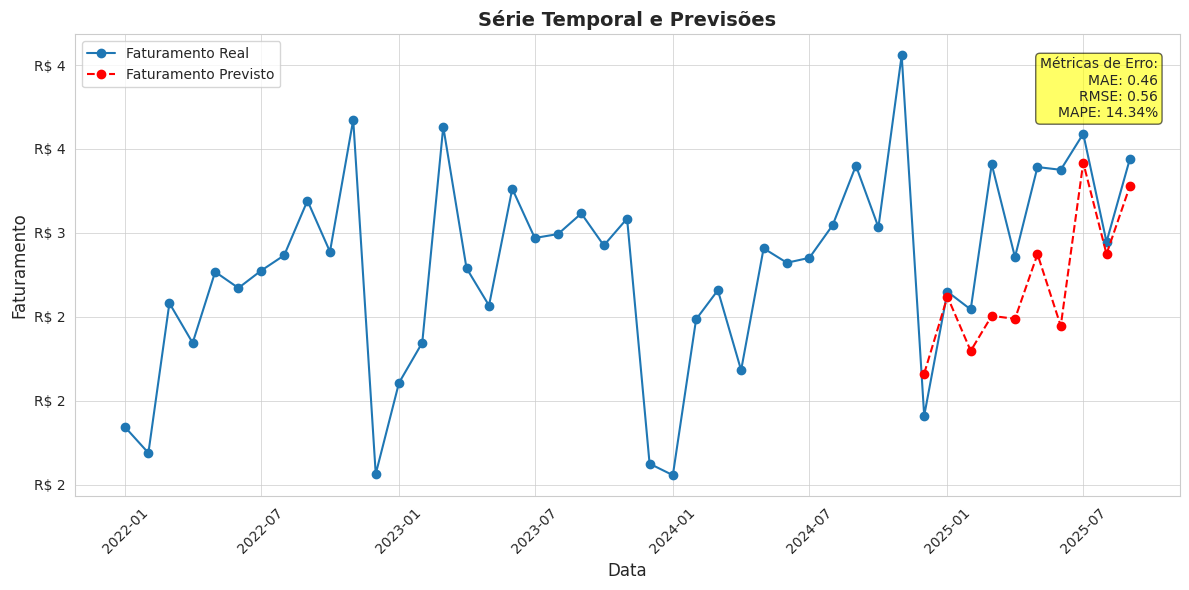

In [39]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax1,
    coluna,
    metricas_sarimax
)

### ARIMA(10, 1, 1) restrito

In [40]:
metricas_sarimax_sparse, df_resultados_sarimax_sparse = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   42
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -30.282
Date:                Sat, 15 Nov 2025   AIC                             68.564
Time:                        10:51:43   BIC                             74.300
Sample:                    01-01-2022   HQIC                            70.434
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.1091      0.298      0.366      0.714      -0.475       0.694
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10           -0.0414      0.237     -0.175      0.861      -0.505       0.422
ma.L1            -0.9660      0.385     -2.511      0.012      -1.720      -0.212
sigma2            0.3800      0.142      2.672      0.008       0.101       0.659
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.64   Prob(JB):                         0.16
Heteroskedasticity (H):               0.96   Skew:                            -0.75
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.50 | RMSE: 0.59 | MAPE: 16.23%


In [41]:
metricas_sarimax_sparse1, df_resultados_sarimax_sparse1 = rolling_forecast_sarimax(
    df, 
    coluna, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            faturamento   No. Observations:                   44
Model:              SARIMAX(10, 1, 1)   Log Likelihood                 -30.951
Date:                Sat, 15 Nov 2025   AIC                             69.903
Time:                        10:51:45   BIC                             75.889
Sample:                    01-01-2022   HQIC                            71.917
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.1453      0.288      0.505      0.614      -0.419       0.709
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10        -5.733e-06      0.147  -3.89e-05      1.000      -0.289       0.289
ma.L1            -0.9365      0.224     -4.178      0.000      -1.376      -0.497
sigma2            0.3656      0.093      3.923      0.000       0.183       0.548
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.73   Prob(JB):                         0.16
Heteroskedasticity (H):               1.05   Skew:                            -0.73
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 0.48 | RMSE: 0.60 | MAPE: 17.13%


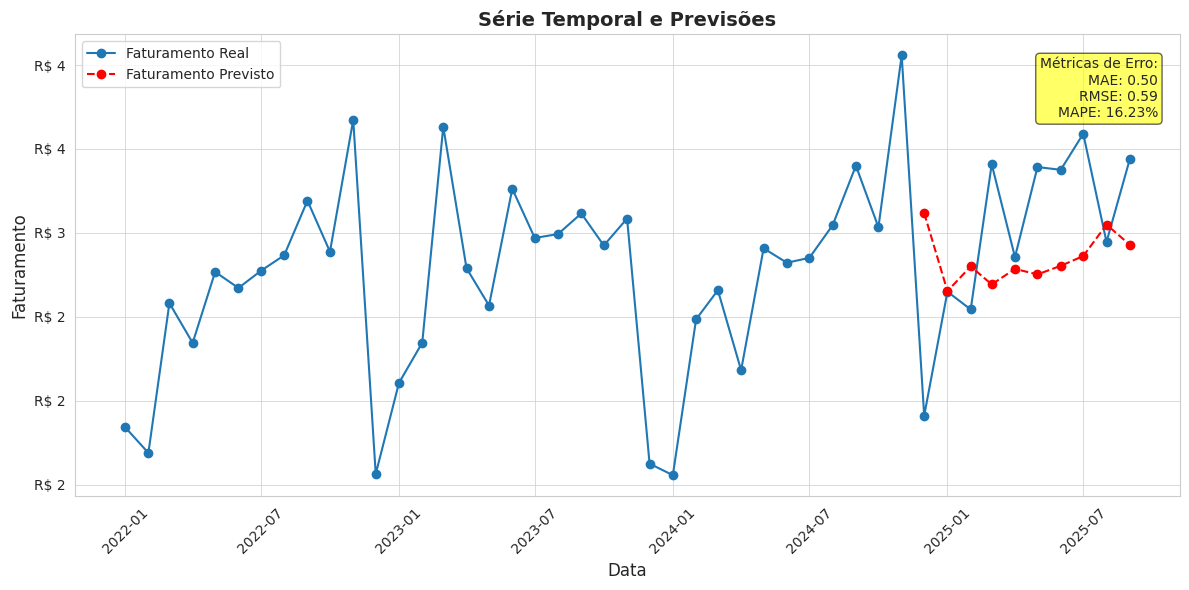

In [42]:
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse1,
    coluna,
    metricas_sarimax_sparse
)

### ARIMA(10, 1, 1) log

In [43]:
metricas_sarimax_log, df_resultados_sarimax_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   42
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   5.432
Date:                Sat, 15 Nov 2025   AIC                             13.135
Time:                        10:51:59   BIC                             30.343
Sample:                    01-01-2022   HQIC                            18.745
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4647      0.437     -1.063      0.288      -1.322       0.392
ar.L2         -0.3881      0.323     -1.201      0.230      -1.021       0.245
ar.L3         -0.5755      0.249     -2.311      0.021      -1.064      -0.087
ar.L4         -0.3389      0.351     -0.965      0.335      -1.027       0.349
ar.L5         -0.3985      0.275     -1.450      0.147      -0.937       0.140
ar.L6         -0.4239      0.239     -1.773      0.076      -0.893       0.045
ar.L7         -0.4481      0.307     -1.458      0.145      -1.050       0.154
ar.L8         -0.2222      0.245     -0.905      0.365      -0.703       0.259
ar.L9         -0.4982      0.148     -3.355      0.001      -0.789      -0.207
ar.L10        -0.4421      0.313     -1.412      0.158      -1.056       0.172
ma.L1         -0.3308      0.542     -0.610      0.542      -1.393       0.731
sigma2         0.0411      0.015      2.679      0.007       0.011       0.071
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.74   Prob(JB):                         0.79
Heteroskedasticity (H):               1.05   Skew:                            -0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(10, 1, 1)) -> MAE: 0.48 | RMSE: 0.57 | MAPE: 15.06%


In [44]:
metricas_sarimax_log1, df_resultados_sarimax_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   44
Model:              SARIMAX(10, 1, 1)   Log Likelihood                   6.777
Date:                Sat, 15 Nov 2025   AIC                             10.447
Time:                        10:52:01   BIC                             28.405
Sample:                    01-01-2022   HQIC                            16.489
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4705      0.407     -1.155      0.248      -1.269       0.328
ar.L2         -0.3875      0.301     -1.289      0.197      -0.977       0.202
ar.L3         -0.5749      0.232     -2.479      0.013      -1.029      -0.120
ar.L4         -0.3382      0.323     -1.046      0.296      -0.972       0.296
ar.L5         -0.3961      0.258     -1.538      0.124      -0.901       0.109
ar.L6         -0.4253      0.221     -1.923      0.055      -0.859       0.008
ar.L7         -0.4587      0.275     -1.665      0.096      -0.999       0.081
ar.L8         -0.2360      0.236     -1.001      0.317      -0.698       0.226
ar.L9         -0.4957      0.138     -3.581      0.000      -0.767      -0.224
ar.L10        -0.4455      0.292     -1.527      0.127      -1.017       0.126
ma.L1         -0.3201      0.505     -0.633      0.527      -1.311       0.671
sigma2         0.0387      0.013      2.974      0.003       0.013       0.064
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.70   Prob(JB):                         0.64
Heteroskedasticity (H):               0.96   Skew:                            -0.22
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=(10, 1, 1)) -> MAE: 0.36 | RMSE: 0.47 | MAPE: 11.58%


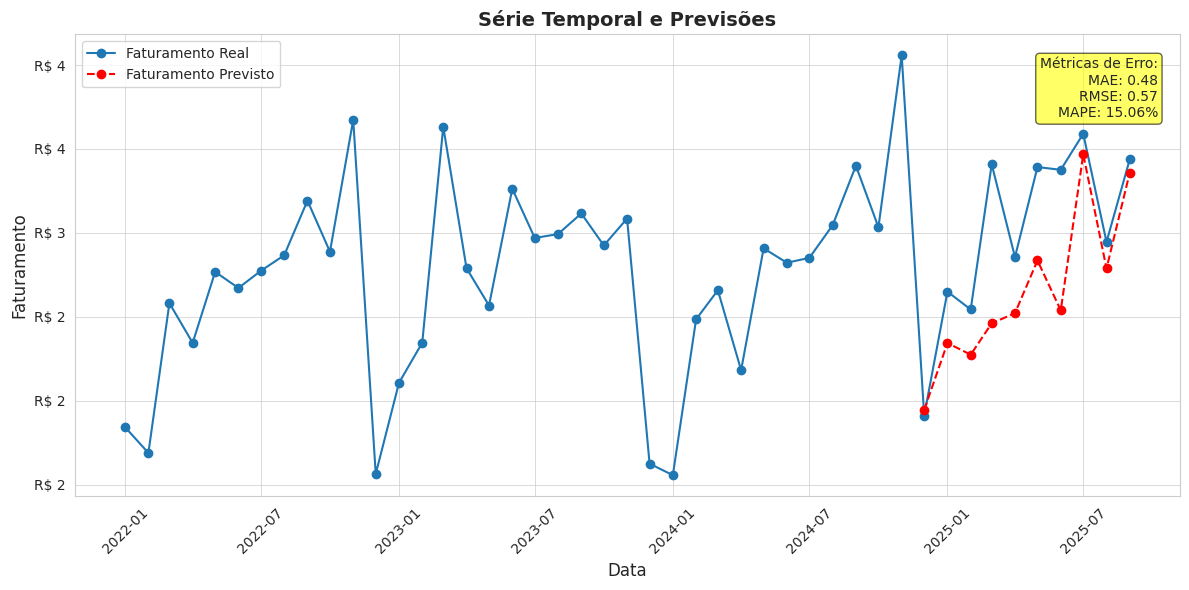

In [45]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_log1,
    coluna,
    metricas_sarimax_log
)

### ARIMA(10, 1, 1) log restrito

In [46]:
metricas_sarimax_sparse_log, df_resultados_sarimax_sparse_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   42
Model:              SARIMAX(10, 1, 1)   Log Likelihood                  -0.584
Date:                Sat, 15 Nov 2025   AIC                              9.167
Time:                        10:54:38   BIC                             14.903
Sample:                    01-01-2022   HQIC                            11.037
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.1967      0.260      0.758      0.449      -0.312       0.706
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10        -5.043e-06      0.057  -8.79e-05      1.000      -0.112       0.112
ma.L1            -1.0000   2199.596     -0.000      1.000   -4312.129    4310.129
sigma2            0.0555    122.173      0.000      1.000    -239.399     239.511
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 9.82
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               0.85   Skew:                            -1.22
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.52 | RMSE: 0.60 | MAPE: 16.64%


In [47]:
metricas_sarimax_sparse_log1, df_resultados_sarimax_sparse_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   44
Model:              SARIMAX(10, 1, 1)   Log Likelihood                  -0.582
Date:                Sat, 15 Nov 2025   AIC                              9.165
Time:                        10:54:40   BIC                             15.151
Sample:                    01-01-2022   HQIC                            11.179
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.2117      0.264      0.802      0.422      -0.305       0.729
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5 (fixed)          0        nan        nan        nan         nan         nan
ar.L6 (fixed)          0        nan        nan        nan         nan         nan
ar.L7 (fixed)          0        nan        nan        nan         nan         nan
ar.L8 (fixed)          0        nan        nan        nan         nan         nan
ar.L9 (fixed)          0        nan        nan        nan         nan         nan
ar.L10            0.0496      0.214      0.232      0.816      -0.369       0.469
ma.L1            -0.9538      0.292     -3.262      0.001      -1.527      -0.381
sigma2            0.0565      0.018      3.075      0.002       0.020       0.092
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.68
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -1.29
Prob(H) (two-sided):                  0.76   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 10], [1], 1)) -> MAE: 0.49 | RMSE: 0.60 | MAPE: 17.24%


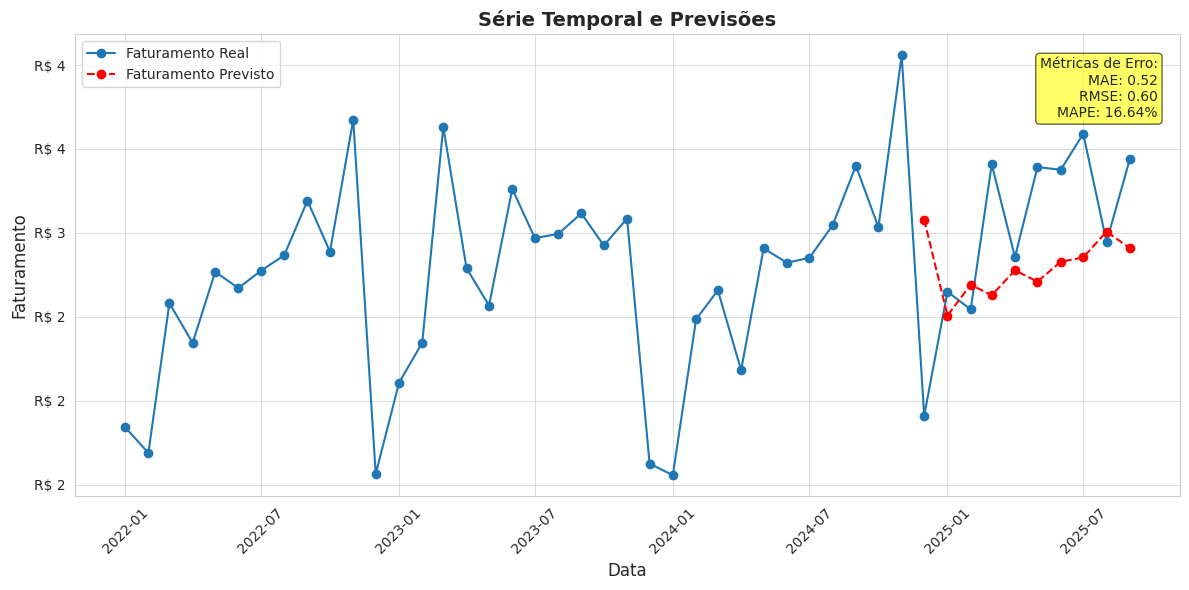

In [48]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_log1,
    coluna,
    metricas_sarimax_sparse_log
)

In [49]:
sarimax_order = (1, 1, 1) 
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [50]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = False,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   42
Model:               SARIMAX(1, 1, 1)   Log Likelihood                   7.590
Date:                Sat, 15 Nov 2025   AIC                             -7.179
Time:                        10:54:52   BIC                             -0.525
Sample:                    01-01-2022   HQIC                            -4.792
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mes_1         -0.6268      0.152     -4.126      0.000      -0.925      -0.329
ar.L1         -0.6527      0.233     -2.802      0.005      -1.109      -0.196
ma.L1         -0.5591      0.169     -3.314      0.001      -0.890      -0.228
sigma2         0.0396      0.008      4.742      0.000       0.023       0.056
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                41.77
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -1.90
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=(1, 1, 1)) -> MAE: 0.36 | RMSE: 0.45 | MAPE: 12.85%


### ARIMA(10, 1, 1) log restrito com endógenas

In [87]:
# [1, 10]	[1]	1	(1, 0, 0, 12)	[3]	
# [1, 5]	[1]	1	(1, 0, 0, 12)	

In [88]:
sarimax_seasonal = (1, 0, 0, 12)

In [93]:
sarimax_sparse_order = ([1, 5], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in []]

In [94]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    35, 
    horizonte=3,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     log_faturamento   No. Observations:                   42
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                  14.422
Date:                             Sat, 15 Nov 2025   AIC                            -18.843
Time:                                     12:38:14   BIC                            -12.953
Sample:                                 01-01-2022   HQIC                           -17.281
                                      - 06-01-2025                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.6022      0.274     -2.201      0.028      -1.138      -0.066
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5            -0.0604      0.274     -0.221      0.825      -0.597       0.476
ma.L1            -0.2720      0.248     -1.097      0.272      -0.758       0.214
ar.S.L12          0.7375      0.098      7.494      0.000       0.545       0.930
sigma2            0.0175      0.005      3.417      0.001       0.007       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.00
Prob(Q):                              0.67   Prob(JB):                         1.00
Heteroskedasticity (H):               0.70   Skew:                             0.03
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.28 | RMSE: 0.33 | MAPE: 9.63%


In [95]:
metricas_sarimax_sparse_endog_log1, df_resultados_sarimax_sparse_endog_log1 = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    35, 
    horizonte=1,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     log_faturamento   No. Observations:                   44
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                  15.642
Date:                             Sat, 15 Nov 2025   AIC                            -21.284
Time:                                     12:38:15   BIC                            -14.994
Sample:                                 01-01-2022   HQIC                           -19.473
                                      - 08-01-2025                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.6094      0.271     -2.245      0.025      -1.141      -0.077
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5            -0.1134      0.249     -0.456      0.649      -0.601       0.375
ma.L1            -0.2692      0.241     -1.118      0.264      -0.741       0.203
ar.S.L12          0.7248      0.095      7.598      0.000       0.538       0.912
sigma2            0.0175      0.005      3.471      0.001       0.008       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.70   Prob(JB):                         0.99
Heteroskedasticity (H):               0.61   Skew:                            -0.04
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=1, Order=([1, 5], [1], 1)) -> MAE: 0.30 | RMSE: 0.36 | MAPE: 10.19%


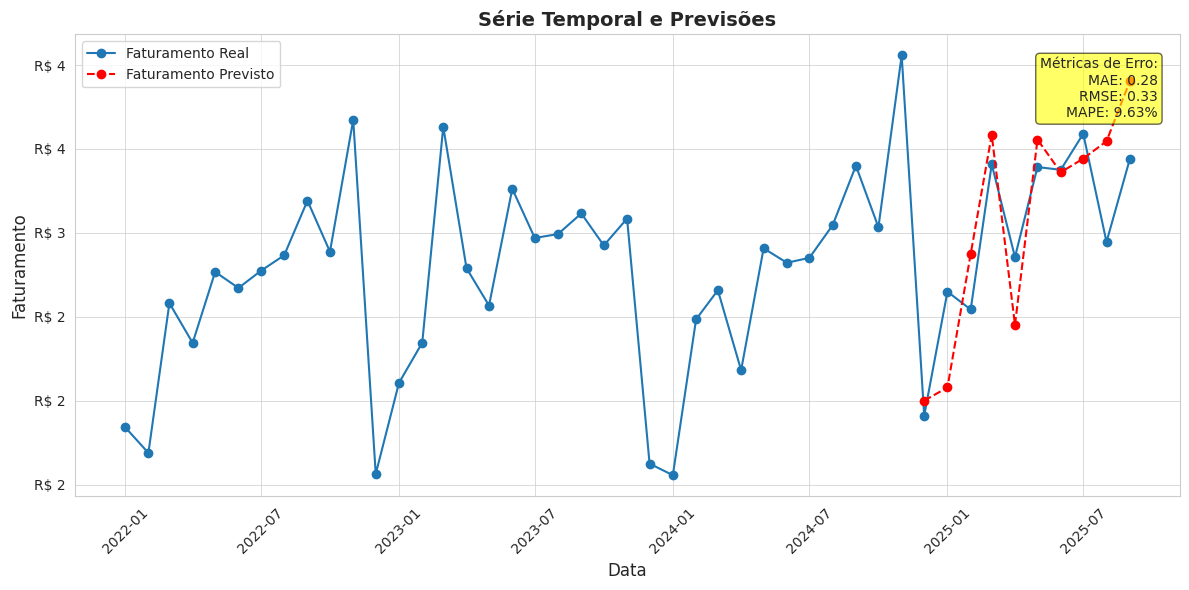

In [96]:
coluna = 'faturamento'
plot_forecast_results(
    df.rename(columns={coluna: 'valor_real'}),
    df_resultados_sarimax_sparse_endog_log1,
    coluna,
    metricas_sarimax_sparse_endog_log
)

## Tunning

In [55]:
sarimax_sparse_order = ([1, 5], [1], 1)
# EXOG_COLS = [f'mes_{m}' for m in [1, 2, 3, 11, 12]]
EXOG_COLS = [f'mes_{m}' for m in [1]]

In [56]:
metricas_sarimax_sparse_endog_log, df_resultados_sarimax_sparse_endog_log = rolling_forecast_sarimax(
    df, 
    coluna_log, 
    periodo_treino_minimo, 
    horizonte=horizonte_previsao,
    order=sarimax_sparse_order,
    seasonal_order=sarimax_seasonal,
    sparse_model = True,
    exp_adjust = True,
    include_constant=False,
    exog_cols=EXOG_COLS
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_faturamento   No. Observations:                   42
Model:               SARIMAX(5, 1, 1)   Log Likelihood                   7.410
Date:                Sat, 15 Nov 2025   AIC                             -4.820
Time:                        10:55:06   BIC                              3.098
Sample:                    01-01-2022   HQIC                            -2.056
                         - 06-01-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
mes_1            -0.6421      0.164     -3.916      0.000      -0.964      -0.321
ar.L1            -0.6635      0.273     -2.429      0.015      -1.199      -0.128
ar.L2 (fixed)          0        nan        nan        nan         nan         nan
ar.L3 (fixed)          0        nan        nan        nan         nan         nan
ar.L4 (fixed)          0        nan        nan        nan         nan         nan
ar.L5             0.0822      0.253      0.325      0.745      -0.413       0.578
ma.L1            -0.6609      0.160     -4.139      0.000      -0.974      -0.348
sigma2            0.0382      0.008      5.017      0.000       0.023       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                28.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -1.67
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.40 | RMSE: 0.48 | MAPE: 13.93%


In [57]:
from itertools import product

In [58]:
def fine_tune_sarimax(historico, coluna_valor, periodo_inicial, horizonte,
                      ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options):
    """
    Realiza um Grid Search para encontrar a melhor combinação de parâmetros SARIMAX esparsos e exógenas.
    """
    
    # Desabilita a exibição do summary a cada iteração
    display_parameters = False 
    
    # 1. Preparação para o Grid Search
    
    # Cria o grid completo de combinações (produto cartesiano)
    param_grid = list(product(ar_lags_options, ma_lags_options, d_options, seasonal_options, exog_options))
    
    results = []
    
    print(f"Iniciando Grid Search com {len(param_grid)} combinações...")
    
    # 2. Loop sobre o Grid
    for ar_lags, ma_lags, d, seasonal_order, months_exog in param_grid:
        
        try:
            # 2.1. Configuração do Modelo
            
            # A ordem é necessária para a função rolling_forecast_sarimax
            order = (ar_lags, ma_lags, d)
            
            # Variáveis Exógenas
            exog_cols = [f'mes_{m}' for m in months_exog]
            
            # Se houver exógenas, o histórico deve ser preparado
            if exog_cols:
                # Função auxiliar para criar as dummies (deve estar definida)
                df_temp = create_month_dummies(historico, months_exog) 
            else:
                df_temp = historico.copy()
            
            # 2.2. Execução do Rolling Forecast
            
            metrics, _ = rolling_forecast_sarimax(
                df_temp, 
                coluna_valor, 
                periodo_inicial, 
                horizonte,
                order=order, 
                seasonal_order=seasonal_order,
                sparse_model=True,  # Força o uso do modelo esparso
                include_constant=False,
                exog_cols=exog_cols,
                 exp_adjust = True,
                display_parameters=display_parameters
            )
            
            # 2.3. Armazenamento dos Resultados
            
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': metrics['MAPE'],
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE']
            })
            
        except Exception as e:
            # Captura falhas de ajuste do modelo (comum no SARIMAX)
            print(f"Falha na combinação AR={ar_lags}, MA={ma_lags}, D={d}, Exog={months_exog}: {e}")
            results.append({
                'ar_lags': ar_lags,
                'ma_lags': ma_lags,
                'd': d,
                'seasonal_order': seasonal_order,
                'exog_months': months_exog,
                'MAPE': np.nan, 'RMSE': np.nan, 'MAE': np.nan
            })

    # 3. Análise dos Resultados
    df_results = pd.DataFrame(results).sort_values(by='MAPE', ascending=True).reset_index(drop=True)
    
    best_model = df_results.iloc[0]
    
    print("\n--- MELHOR MODELO ENCONTRADO ---")
    print(f"MAPE Mínimo: {best_model['MAPE']:.2f}%")
    print(f"AR Lags: {best_model['ar_lags']}")
    print(f"MA Lags: {best_model['ma_lags']}")
    print(f"I: {best_model['d']}")
    print(f"Sazonal: {best_model['seasonal_order']}")
    print(f"Exógenas: {best_model['exog_months']}")
    
    return df_results, best_model

In [84]:
# DEFINIÇÃO DO GRID
AR_LAGS_OPTIONS = [[1], [1, 5], [1, 10]]
MA_LAGS_OPTIONS = [[1], [1, 2]]
D_OPTIONS = [1]
SEASONAL_OPTIONS = [(0, 0, 0, 0), (1, 0, 0, 12)]
EXOG_OPTIONS = [[], [1], [3], [1, 3], [1, 5], [1, 3, 11, 12]]

# EXECUÇÃO
df_tuning_results, melhor_modelo = fine_tune_sarimax(
    historico=df,
    coluna_valor='log_faturamento',
    periodo_inicial=35,
    horizonte=3,
    ar_lags_options=AR_LAGS_OPTIONS,
    ma_lags_options=MA_LAGS_OPTIONS,
    d_options=D_OPTIONS,
    seasonal_options=SEASONAL_OPTIONS,
    exog_options=EXOG_OPTIONS
)

Iniciando Grid Search com 72 combinações...
Erro ao ajustar o SARIMAX no passo 35 (Treino até 2024-11-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 36 (Treino até 2024-12-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 37 (Treino até 2025-01-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 38 (Treino até 2025-02-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 39 (Treino até 2025-03-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 40 (Treino até 2025-04-01 00:00:00): A máscara de parâmetros não gerou restrições. Verifique ar_lags e ma_lags.
Erro ao ajustar o SARIMAX no passo 41 (Treino até 2025-05-01 00:00:00): A 

/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.28 | RMSE: 0.33 | MAPE: 9.63%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.37 | RMSE: 0.44 | MAPE: 12.89%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.37 | RMSE: 0.43 | MAPE: 12.49%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.43 | RMSE: 0.53 | MAPE: 14.41%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.44 | RMSE: 0.52 | MAPE: 15.08%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1], 1)) -> MAE: 0.60 | RMSE: 0.69 | MAPE: 18.93%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.54 | RMSE: 0.61 | MAPE: 17.37%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.45 | RMSE: 0.52 | MAPE: 15.64%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.48 | RMSE: 0.56 | MAPE: 15.55%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.45 | RMSE: 0.50 | MAPE: 15.48%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.46 | RMSE: 0.52 | MAPE: 15.91%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.47 | RMSE: 0.56 | MAPE: 15.68%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.29 | RMSE: 0.34 | MAPE: 9.87%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.39 | RMSE: 0.47 | MAPE: 13.54%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.40 | RMSE: 0.46 | MAPE: 13.20%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.47 | RMSE: 0.57 | MAPE: 15.49%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.54 | RMSE: 0.68 | MAPE: 18.33%
Rolling Forecast SARIMAX (h=3, Order=([1, 5], [1, 2], 1)) -> MAE: 0.54 | RMSE: 0.64 | MAPE: 17.74%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.52 | RMSE: 0.60 | MAPE: 16.64%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.36 | RMSE: 0.47 | MAPE: 12.88%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.45 | RMSE: 0.55 | MAPE: 14.73%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.36 | RMSE: 0.48 | MAPE: 12.93%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.39 | RMSE: 0.50 | MAPE: 13.84%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.50 | RMSE: 0.56 | MAPE: 16.39%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.37 | RMSE: 0.46 | MAPE: 12.21%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.34 | RMSE: 0.42 | MAPE: 11.30%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.50 | RMSE: 0.61 | MAPE: 16.47%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.55 | RMSE: 0.66 | MAPE: 18.14%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.73 | RMSE: 1.15 | MAPE: 23.19%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1], 1)) -> MAE: 0.57 | RMSE: 0.65 | MAPE: 18.52%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.68 | RMSE: 0.82 | MAPE: 23.28%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.34 | RMSE: 0.47 | MAPE: 11.95%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.68 | RMSE: 0.84 | MAPE: 23.76%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.32 | RMSE: 0.45 | MAPE: 11.29%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.39 | RMSE: 0.50 | MAPE: 13.38%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.67 | RMSE: 0.77 | MAPE: 21.58%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.35 | RMSE: 0.43 | MAPE: 11.07%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.31 | RMSE: 0.40 | MAPE: 9.69%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.54 | RMSE: 0.65 | MAPE: 17.67%


/home/alcides/projeto-timeseries/.env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.54 | RMSE: 0.64 | MAPE: 17.58%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.56 | RMSE: 0.71 | MAPE: 17.76%
Rolling Forecast SARIMAX (h=3, Order=([1, 10], [1, 2], 1)) -> MAE: 0.50 | RMSE: 0.61 | MAPE: 16.41%

--- MELHOR MODELO ENCONTRADO ---
MAPE Mínimo: 9.63%
AR Lags: [1, 5]
MA Lags: [1]
I: 1
Sazonal: (1, 0, 0, 12)
Exógenas: []


In [85]:
df_tuning_results, melhor_modelo

(    ar_lags ma_lags  d seasonal_order     exog_months       MAPE      RMSE  \
 0    [1, 5]     [1]  1  (1, 0, 0, 12)              []   9.632265  0.334448   
 1   [1, 10]  [1, 2]  1  (1, 0, 0, 12)             [1]   9.692773  0.395187   
 2    [1, 5]  [1, 2]  1  (1, 0, 0, 12)              []   9.869848  0.344458   
 3   [1, 10]  [1, 2]  1  (1, 0, 0, 12)              []  11.070512  0.430720   
 4   [1, 10]  [1, 2]  1   (0, 0, 0, 0)          [1, 3]  11.290868  0.453726   
 ..      ...     ... ..            ...             ...        ...       ...   
 67      [1]  [1, 2]  1  (1, 0, 0, 12)             [1]        NaN       NaN   
 68      [1]  [1, 2]  1  (1, 0, 0, 12)             [3]        NaN       NaN   
 69      [1]  [1, 2]  1  (1, 0, 0, 12)          [1, 3]        NaN       NaN   
 70      [1]  [1, 2]  1  (1, 0, 0, 12)          [1, 5]        NaN       NaN   
 71      [1]  [1, 2]  1  (1, 0, 0, 12)  [1, 3, 11, 12]        NaN       NaN   
 
          MAE  
 0   0.282959  
 1   0.308134  
 2

In [86]:
df_tuning_results

,ar_lags,ma_lags,d,seasonal_order,exog_months,MAPE,RMSE,MAE
0,"[1, 5]",[1],1,"(1, 0, 0, 12)",[],9.632265,0.334448,0.282959
1,"[1, 10]","[1, 2]",1,"(1, 0, 0, 12)",[1],9.692773,0.395187,0.308134
2,"[1, 5]","[1, 2]",1,"(1, 0, 0, 12)",[],9.869848,0.344458,0.290928
3,"[1, 10]","[1, 2]",1,"(1, 0, 0, 12)",[],11.070512,0.430720,0.346866
4,"[1, 10]","[1, 2]",1,"(0, 0, 0, 0)","[1, 3]",11.290868,0.453726,0.319783
...,...,...,...,...,...,...,...,...
67,[1],"[1, 2]",1,"(1, 0, 0, 12)",[1],NaN,NaN,NaN
68,[1],"[1, 2]",1,"(1, 0, 0, 12)",[3],NaN,NaN,NaN
69,[1],"[1, 2]",1,"(1, 0, 0, 12)","[1, 3]",NaN,NaN,NaN
70,[1],"[1, 2]",1,"(1, 0, 0, 12)","[1, 5]",NaN,NaN,NaN
